In [10]:
import os
import random
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from himalaya.backend import set_backend
from scipy.interpolate import griddata, CloughTocher2DInterpolator

from compare_variance_residual.residual import residual_method
from compare_variance_residual.simulation import generate_dataset
from compare_variance_residual.variance_partitioning import variance_partitioning

matplotlib.interactive(True)

# Generate scalar points

In [11]:
SUBDIVISIONS = 1

In [12]:
scalars_list = [[1,0,0], [0,1,0], [0,0,1]]
scalars_list = np.array(scalars_list)
for i in range(SUBDIVISIONS):
    _scalars_list = []
    for point_1 in range(len(scalars_list)):
        for point_2 in range(point_1, len(scalars_list)):
            interpolation = (scalars_list[point_1] + scalars_list[point_2]) / 2
            _scalars_list.append(interpolation)
    scalars_list = _scalars_list
scalars_list

[array([1., 0., 0.]),
 array([0.5, 0.5, 0. ]),
 array([0.5, 0. , 0.5]),
 array([0., 1., 0.]),
 array([0. , 0.5, 0.5]),
 array([0., 0., 1.])]

# Generate data

In [13]:
backend = set_backend("cupy", on_error="warn")
warnings.filterwarnings("ignore")
random.seed(42)

In [14]:
d_list = [100, 100, 100]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
noise_scalar = 0.1

cv = 10
alphas = np.logspace(-5, 5, 10)

In [15]:
path = os.path.join("results", f"targets={n_targets}", f"samples={n_samples}", f"noise={noise_scalar}", f"cv={cv}",
                    f"alphas={alphas.min()},{alphas.max()},{len(alphas)}", "varying scalars")
os.makedirs(path, exist_ok=True)

In [ ]:
for scalars in scalars_list:
    print(scalars)
    csv_path = os.path.join(path, f"scores_{scalars}.csv")
    if  os.path.exists(csv_path):
        print("skipping, already exists")
        continue
    Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_scalar)
    x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score = variance_partitioning(
        Xs, Y, n_samples_train, alphas, cv)
    print("variance partitioning done")
    _, _, x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score = residual_method(
        Xs, Y, n_samples_train, alphas, cv)
    print("residual method done")
    scores = pd.DataFrame()
    scores["x1_score"] = x1_score
    scores["x2_score"] = x2_score
    scores["vp_joint_score"] = joint_score
    scores["vp_shared_score"] = x1_and_x2_score
    scores["vp_x1_unique_score"] = vp_x1_unique_score
    scores["vp_x2_unique_score"] = vp_x2_unique_score

    scores["rm_x2_to_x1_score"] = np.concatenate(
        [x2_to_x1_score, np.full(len(x1_score) - len(x2_to_x1_score), np.nan)])
    scores["rm_x1_to_x2_score"] = np.concatenate(
        [x1_to_x2_score, np.full(len(x2_score) - len(x1_to_x2_score), np.nan)])
    scores["rm_x1_unique_score"] = rm_x1_unique_score
    scores["rm_x2_unique_score"] = rm_x2_unique_score
    print(scores.head())

    scores.to_csv(csv_path, index=False)

[1. 0. 0.]


plot points on triangle simplex

In [17]:
def plot_simplex(metric_values, interp_type='linear'):
    """Plots a simplex heatmap based on provided metric values.

    Args:
        metric_values: A list or numpy array of metric values corresponding to each point in the simplex.
                      The length must match the number of generated scalar points.
        interp_type: Type of interpolation to use. Can be 'linear', 'clough_tocher', or 'cubic'. Defaults to 'linear'.
    """
    if len(metric_values) != len(scalars):
        raise ValueError("Length of metric_values must match the number of scalar points.")

    if interp_type not in ['linear', 'clough_tocher', 'cubic']:
        raise ValueError("Invalid interpolation type. Choose 'linear', 'clough_tocher', or 'cubic'.")

    # Convert to barycentric coordinates
    barycentric_coords = scalars

    # Create the simplex plot
    fig, ax = plt.subplots()

    # Define simplex corners
    corners = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2]])

    # Transform barycentric coordinates to Cartesian
    cartesian_coords = np.dot(barycentric_coords, corners)

    # Create a colormap
    cmap = plt.get_cmap('seismic')  # You can change the colormap as needed

    # Create grid for interpolation
    resolution = 100  # Adjust resolution as needed
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, np.sqrt(3) / 2, resolution)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Filter grid points that are outside the triangle
    triangle = matplotlib.patches.Polygon(corners, closed=True)
    mask = triangle.contains_points(grid_points)
    grid_points_filtered = grid_points[mask]

    # Interpolate values on the grid
    if interp_type == 'linear':
        interp_values = griddata(cartesian_coords, metric_values, grid_points_filtered, method='linear')
    elif interp_type == 'clough_tocher':
        interp = CloughTocher2DInterpolator(cartesian_coords, metric_values)
        interp_values = interp(grid_points_filtered)
    elif interp_type == 'cubic':
        interp_values = griddata(cartesian_coords, metric_values, grid_points_filtered, method='cubic')

    # Reshape interpolated values
    zz = np.full_like(xx.ravel(), np.nan)
    zz[mask] = interp_values
    zz = zz.reshape(xx.shape)

    # Plot the colored triangle
    im = ax.imshow(zz, extent=[0, 1, 0, np.sqrt(3) / 2], origin='lower', cmap=cmap, aspect='auto')

    # Add a colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Metric Value')

    # Draw the triangle boundaries (optional, if you want to highlight them)
    ax.plot([corners[0, 0], corners[1, 0]], [corners[0, 1], corners[1, 1]], 'k-')
    ax.plot([corners[1, 0], corners[2, 0]], [corners[1, 1], corners[2, 1]], 'k-')
    ax.plot([corners[2, 0], corners[0, 0]], [corners[2, 1], corners[0, 1]], 'k-')

    # Set axis labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Simplex Heatmap')

    # Show plot
    plt.show()


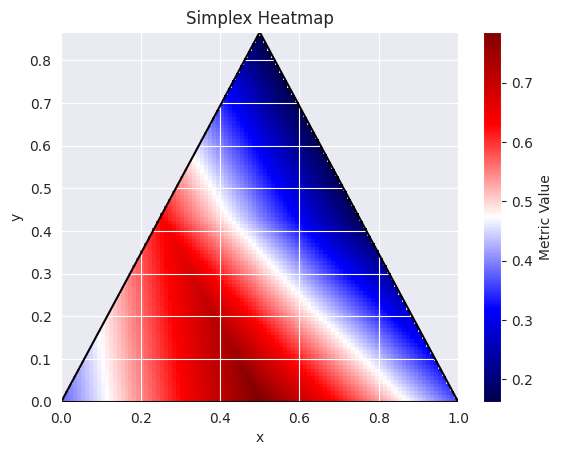

In [18]:
plot_simplex(np.random.rand(len(scalars)))